In [1]:
%pip install tensorflow numpy pandas matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import deque
import random


In [3]:
class SchedulingEnv:
    def __init__(self):
        self.time_blocks = 24  # 24 hours in a day
        self.productivity = np.zeros(self.time_blocks)  # Initialize productivity levels
        self.current_time = 0  # Start from hour 0
        
    def reset(self):
        self.productivity = np.zeros(self.time_blocks)
        self.current_time = 0
        return self.current_time
    
    def step(self, action):
        done = False
        reward = 0
        # If action is '1', the user is working during that time
        if action == 1:
            self.productivity[self.current_time] = 1  # Productive hour
            reward = 1
        else:
            self.productivity[self.current_time] = 0  # Non-productive hour
        
        self.current_time += 1
        
        # If we have reached the end of the day
        if self.current_time >= self.time_blocks:
            done = True
        
        return self.current_time, reward, done

env = SchedulingEnv()


In [4]:
class DQNAgent:
    def __init__(self):
        self.state_size = 1  # Current time block
        self.action_size = 2  # Either study/work (1) or rest (0)
        self.memory = deque(maxlen=2000)  # Replay memory
        self.gamma = 0.95  # Discount factor
        self.epsilon = 1.0  # Exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self.build_model()

    def build_model(self):
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(tf.keras.layers.Dense(24, activation='relu'))
        model.add(tf.keras.layers.Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(lr=self.learning_rate))
        return model
    
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
    
    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])
    
    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = (reward + self.gamma * np.amax(self.model.predict(next_state)[0]))
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

agent = DQNAgent()


In [5]:
episodes = 14  # Simulating over 2 weeks
batch_size = 32

for e in range(episodes):
    state = np.reshape(env.reset(), [1, 1])
    for time_block in range(env.time_blocks):
        action = agent.act(state)
        next_state, reward, done = env.step(action)
        next_state = np.reshape(next_state, [1, 1])
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        if done:
            print(f"Day {e+1}/{episodes} completed with productivity: {sum(env.productivity)}")
            break
    if len(agent.memory) > batch_size:
        agent.replay(batch_size)


Day 1/14 completed with productivity: 10.0
Day 2/14 completed with productivity: 14.0
1/1 [==============================] - 0s 17ms/step
Day 3/14 completed with productivity: 16.0
1/1 [==============================] - 0s 14ms/step
Day 4/14 completed with productivity: 9.0
1/1 [==============================] - 0s 15ms/step
Day 5/14 completed with productivity: 13.0
1/1 [==============================] - 0s 15ms/step
Day 6/14 completed with productivity: 12.0
1/1 [==============================] - 0s 14ms/step
Day 7/14 completed with productivity: 12.0
1/1 [==============================] - 0s 15ms/step
Day 8/14 completed with productivity: 12.0
1/1 [==============================] - 0s 16ms/step
Day 9/14 completed with productivity: 10.0
1/1 [==============================] - 0s 15ms/step
Day 10/14 completed with productivity: 9.0
1/1 [==============================] - 0s 17ms/step
Day 11/14 completed with productivity: 13.0
1/1 [==============================] - 0s 16ms/step
Day 12/

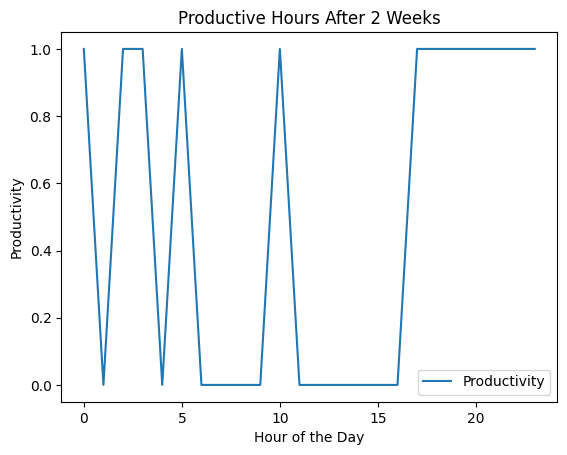

In [6]:
plt.plot(env.productivity, label='Productivity')
plt.title('Productive Hours After 2 Weeks')
plt.xlabel('Hour of the Day')
plt.ylabel('Productivity')
plt.legend()
plt.show()
